# Tutorial 7 - Transformers

In this tutorial, we will build a GPT language model with PyTorch from scratch.

As a reminder:

- **BERT, RoBERTa, DistilBERT** -> encoder-only transformers
- **T5, T5XXL** -> encoder-decoder transformers
- **GPT, GPT-2, GPT-3, GPT-4** are decoder-only transformers



Useful resources:
- [Attention is all you need](https://arxiv.org/abs/1706.03762)
- [GPT-3 paper](https://arxiv.org/pdf/2005.14165)

# GPT architecture below as reference

In [1]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

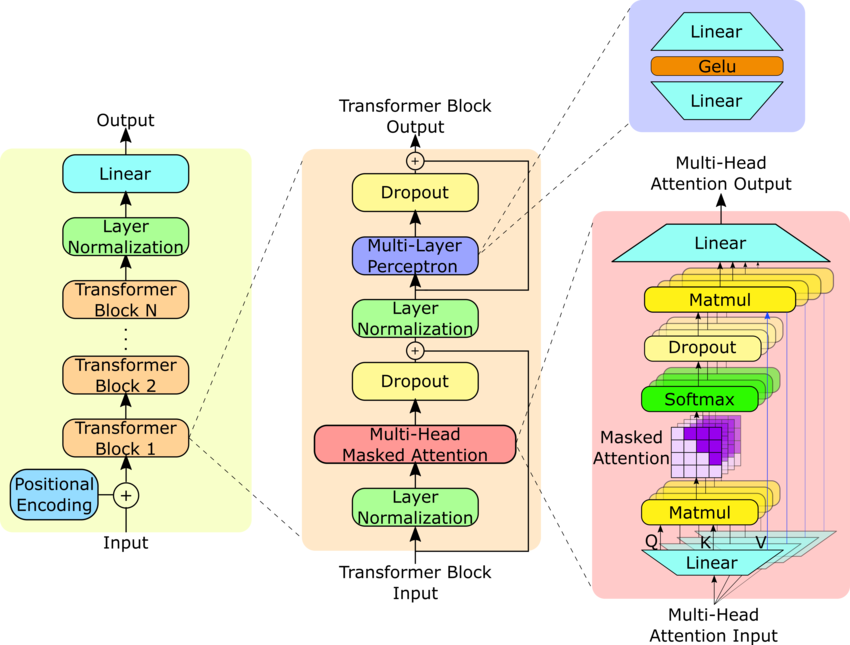

# LayerNorm

Build a [Layer norm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) module from scratch. Have a look at the formula. Do not use the PyTorch module to do this



In [ ]:
class LayerNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    y = ((x - x.mean(1, keepdim=True) )/ (torch.sqrt((x.var(1, keepdim=True)) + self.eps))) * self.gamma + self.beta
    return y

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape


torch.Size([32, 100])

# Single attention head

Remember the attention formula:

$Attention (\mathbf{Q}, \mathbf{K}, \mathbf{V})=\operatorname{softmax}\left(\frac{\mathbf{Q K}^{\top}}{\sqrt{n}}\right) \mathbf{V},$

Have a look at the above architecture to fill in the rest. Remember are trying to build a masked-attention layer. You will want to use [PyTorch tril](https://pytorch.org/docs/stable/generated/torch.tril.html) function for this.


In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, block_size, n_embd, dropout: int):
        super().__init__()
        #Self attention, need to train the weights of our matrix.
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        attention = nn.Softmax(torch.matmul(self.query, self.key) / torch.sqrt())
        
        # att = nn.tril

# Multi Head Attention
Simply create multiple attention heads, concatenate their results, then pass them through a linear and dropout layers.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout: int):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=1)
        

# FeedForward network

Transformers use feedforward networks after the MultiHead attention. The structure should be:

1. Linear(n_embed, 4*n_embed)
2. ReLU
3. Linear(4*n_embed, n_embed)
4. Dropout

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout()
        )


        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        return self.net(x)


        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

# Transformer block

Finally, let's combine the above into a transformer block.

The structure for this one should be:

1. LayerNorm
2. MultiHead attention
3. LayerNorm
4. FeedForward

Remember that transformers use skip connection.

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        
        x = x + self.sa(self.ln1(x))
        x = x + self.sa(self.ln1(x))

        return x
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################



        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

### Download data

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-11-19 12:05:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.008s  

2024-11-19 12:05:04 (132 MB/s) - ‘input.txt’ saved [1115394/1115394]



# Embedding layers

We use some very simple character-wise embedding layer. Big transformers normally usually use [Byte-Pair Encoding](https://huggingface.co/learn/nlp-course/en/chapter6/5)

In [ ]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Decoder-only transformer

Let's put things together to create a simple bigram language model.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################



        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



# Training code

Data loading and training code

In [ ]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # Training loop
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################



    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.3381, val loss 4.3385
step 100: train loss 2.6582, val loss 2.6616
step 200: train loss 2.5122, val loss 2.5189
step 300: train loss 2.4180, val loss 2.4262
step 400: train loss 2.3470, val loss 2.3622
step 500: train loss 2.2987, val loss 2.3057
step 600: train loss 2.2511, val loss 2.2739
step 700: train loss 2.2024, val loss 2.2248
step 800: train loss 2.1583, val loss 2.1778
step 900: train loss 2.1328, val loss 2.1537
step 1000: train loss 2.0909, val loss 2.1396
step 1100: train loss 2.0702, val loss 2.1096
step 1200: train loss 2.0483, val loss 2.1036
step 1300: train loss 2.0118, val loss 2.0558
step 1400: train loss 1.9913, val loss 2.0541
step 1500: train loss 1.9599, val loss 2.0351
step 1600: train loss 1.9430, val loss 2.0152
step 1700: train loss 1.9349, val loss 2.0091
step 1800: train loss 1.9070, val loss 1.9941
step 1900: train loss 1.8923, val loss 1.9859
step 2000: train loss 1.8822, val loss 1.9918
step 2100: train loss 1.